# Test of GraphSAGE
- the version2 of larger hidden dimension
- use DGL
- predict `graphs`
- valid, test data are in the training dataset

In [1]:
import os
import dgl
import json
import torch
import torch as th
import dgl.nn as dglnn
# from tqdm import tqdm
from tqdm.notebook import tqdm  # 使用 notebook 版本的 tqdm
import torch.nn as nn
from dgl.nn import GraphConv, GATConv, SAGEConv
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import get_linear_schedule_with_warmup

- check the GPU and assign the GPU by the best memory usage

In [2]:
import subprocess
import torch

def get_free_gpu():
    try:
        # Run nvidia-smi command to get GPU details
        _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
        command = "nvidia-smi --query-gpu=memory.free --format=csv,nounits,noheader"
        memory_free_info = _output_to_list(subprocess.check_output(command.split())) 
        memory_free_values = [int(x) for i, x in enumerate(memory_free_info)]
        
        # Get the GPU with the maximum free memory
        best_gpu_id = memory_free_values.index(max(memory_free_values))
        return best_gpu_id
    except:
        # If any exception occurs, default to GPU 0 (this handles cases where nvidia-smi isn't installed)
        return 0

if torch.cuda.is_available():
    # Get the best GPU ID based on free memory and set it
    best_gpu_id = get_free_gpu()
    device = torch.device(f"cuda:{best_gpu_id}")
else:
    device = torch.device("cpu")
    print("there's no available GPU")

# device = torch.device(f"cuda:{1}")
print(device)


cuda:3


## Fix the seed

In [3]:
import numpy as np
import torch
import random

#fix seed
def same_seeds(seed = 8787):
    torch.manual_seed(seed)
    # random.seed(seed) 
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## Data Loader

In [4]:
class GraphDataset(Dataset):
    def __init__(self, data_list, device):
        self.data_list = data_list
        self.device = device

    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        return data

def collate(samples):
    data_list = samples
    batched_graphs = []
    for data in data_list:
        g = dgl.graph((th.tensor(data["edge_index"][0]), th.tensor(data["edge_index"][1])), num_nodes=data["num_nodes"])

        g.ndata['feat'] = th.tensor(data["node_feat"])
        g.edata['feat'] = th.tensor(data["edge_attr"])
        g.edata['label'] = th.tensor(data["labels"])  # Add edge labels to graph

        batched_graphs.append(g)
    
    return dgl.batch(batched_graphs)

In [5]:
datasets = ['repeat_train_320', 'valid', 'test']
# datasets = ['valid']
dataset_data = {}

for dataset_name in tqdm(datasets):
    file_path = f"../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/{dataset_name}.jsonl"
    
    print(file_path)
    with open(file_path) as f:
        data_list = [json.loads(line) for line in tqdm(f, position=0, leave=True)]
    
    
    dataset_data[dataset_name] = GraphDataset(data_list, device)

print("Datasets loaded!")

  0%|          | 0/3 [00:00<?, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/repeat_train_320.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/valid.jsonl


0it [00:00, ?it/s]

../../data_processing/dgl/data_new/exp3/training_data_repeat/transR_50/test.jsonl


0it [00:00, ?it/s]

Datasets loaded!


- choose batch size

In [6]:
def create_dataloaders(batch_size, shuffle=True):
    dataloaders = {}
    for dataset_name, dataset in dataset_data.items():
        # do not shuffle the testing dataset
        if dataset_name == "test":
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate)    
        else:
            dataloaders[dataset_name] = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate)
    return dataloaders

dataloaders = create_dataloaders(64)

- Turn the print message to a log file

In [8]:
import datetime

now = datetime.datetime.now()

formatted_time = now.strftime("%m%d_%H:%M")

log_file_path = f"../log_message/{formatted_time}_GraphSAGE_transR_50.log"

def add_log_msg(msg, log_file_path=log_file_path):
    with open(log_file_path, 'a') as f:
        f.write(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}\n')
    print(f'{datetime.datetime.now().strftime("%m/%d/%Y, %H:%M:%S")}# {msg}')

print(log_file_path)

../log_message/1017_10:48_GraphSAGE_transR_50.log


### Model

In [9]:
class GraphSAGE(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(GraphSAGE, self).__init__()
        self.layer1 = dglnn.SAGEConv(in_dim, hidden_dim, 'pool')
        self.layer2 = dglnn.SAGEConv(hidden_dim, out_dim, 'pool')
        self.dropout = nn.Dropout(0.25)

    def forward(self, g, inputs):
        h = self.layer1(g, inputs)
        h = torch.relu(h)
#         h = self.dropout(h)
        h = self.layer2(g, h)
        return h

In [10]:
class MLPPredictor(nn.Module):
    def __init__(self, out_feats, out_classes):
        super().__init__()
        self.W = nn.Linear(out_feats*2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [11]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, num_classes):
        super().__init__()
        self.sage = GraphSAGE(in_features, hidden_features, out_features)
        self.pred = MLPPredictor(out_features, num_classes)
      
    def forward(self, g, node_feat, return_logits=False):
        h = self.sage(g, node_feat)
        logits = self.pred(g, h)
        
        return logits

- Model Forward  

In [18]:
def model_fn(batched_g, model, criterion, device, count=1, which_type='train'):
    """Forward a batch through the model."""
#     batched_g, labels = data
    batched_g = batched_g.to(device)
    
    labels = batched_g.edata['label'].to(device)
    
    logits = model(batched_g, batched_g.ndata['feat'].float())

    loss = criterion(logits, labels)

    output = torch.softmax(logits, dim=1)
    preds = output.argmax(1)
    
    # Compute accuracy
    accuracy = torch.mean((preds == labels).float())
    
    if which_type == 'validation' and count % 1000 == 0:
        add_log_msg(f"labels of Validation: {labels} {labels.shape}")
        add_log_msg(f"predicted of Validation: {preds} {preds.shape}")
        
    elif which_type == 'test'  and count % 1000 == 0:
        add_log_msg(f"labels of Test: {labels} {labels.shape}")
        add_log_msg(f"predicted of Test: {preds} {preds.shape}")
        
    if count % 50000 == 0: 
        add_log_msg(f"labels of {count}: {labels} {labels.shape}")
        add_log_msg(f"predicted of {count}: {preds} {preds.shape}")
        
    return loss, accuracy, preds

### Training

- Fix the seed and save the model.state_dict that contains the initial weight

In [13]:
seed = 8787
same_seeds(seed)

model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
torch.save(model.state_dict(), 'model3_initial(graphsage)/initial_weight.pth')

In [14]:
# model.layer1.fc_self.weight
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

- Check if model really load the model_dict

In [15]:
model = Model(in_features=50, hidden_features=64, out_features=128, num_classes=167)
model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
model.sage.layer1.fc_self.weight

Parameter containing:
tensor([[-0.0682,  0.0153, -0.1769,  ...,  0.0375,  0.2321, -0.2812],
        [-0.2271,  0.2290, -0.1997,  ..., -0.0095,  0.1509,  0.2686],
        [-0.2743,  0.0406, -0.1222,  ...,  0.1036, -0.1590, -0.2555],
        ...,
        [-0.0758,  0.0461,  0.1273,  ...,  0.1367,  0.0671, -0.2605],
        [-0.2425, -0.1362,  0.2474,  ..., -0.3221, -0.0595,  0.3141],
        [ 0.0234, -0.2783,  0.2146,  ..., -0.3020, -0.1751,  0.0528]],
       requires_grad=True)

In [16]:
mapping_file = './new_mapping.txt'
label_mapping = {}
with open(mapping_file, 'r') as f:
    for line in f:
        parts = line.strip().split(': ')
        label_mapping[int(parts[1])] = parts[0]

In [17]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

model = Model(in_features=50, hidden_features=256, out_features=512, num_classes=167)
# model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50_hidden_dim_2.pt"

model = model.to(device)

# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
optimizer = AdamW(model.parameters(), lr=5e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=18, num_training_steps=total_steps)

# T_max control the period of the lr changing -> set 1/10 first
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=36, eta_min=0, last_epoch=- 1, verbose=False)

criterion = nn.CrossEntropyLoss()
# criterion = torch.nn.BCEWithLogitsLoss()

total_steps = 7

# save the best model
best_val_loss = float('inf')
patience = 4  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.
early_stop = False

# Training Part
for epoch in tqdm(range(total_steps)):
    # Train
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    for batched_g in tqdm(dataloaders['repeat_train_320'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

        
#     scheduler.step()
    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')

    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0


    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            early_stop = True
            
    if epoch == total_steps - 1 or early_stop == True:  # Last epoch
        pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50_hidden_dim_2.pt'
        model.load_state_dict(torch.load(pretrained_model_path))
        model.to(device)
        
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for batched_g in tqdm(dataloaders['repeat_train_320'], desc="Generating Train Report", position=0, leave=True):
                loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, which_type='train')
                labels = batched_g.edata['label'].to(device)
                
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        # Assuming that the mapping and other things are defined earlier or globally
        mapped_true_labels = [label_mapping[label] for label in true_labels]
        mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

        # Generate classification report
        train_report = classification_report(mapped_true_labels, mapped_predicted_labels)
        add_log_msg(f"Train Classification Report at Epoch {epoch}:\n{train_report}")

    
    if early_stop:
        add_log_msg("============================== Early stopping ==================================")
        break 

  0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/17/2023, 10:50:46# labels of 5000: tensor([ 38,   9,  24,  75, 164,  83,  24,  24, 163, 125, 125,  12,  31,  74,
        150,   2, 150,  33,  48,  11, 158,  36,  18, 116, 121,   2,   4, 151,
        142, 121,  47,  48,  55,   4,  34,  30,  11,  48, 144, 164, 125, 157,
         34,  87,  55,   9,  48,  31,  12, 125, 150,  47,  48,  48,  49, 151,
        158,  55, 163,  74,  34,  14,  81, 142], device='cuda:3') torch.Size([64])
10/17/2023, 10:50:46# predicted of 5000: tensor([125,  30,  30, 125, 125,  30, 125, 125, 125,  30,   9,  30, 125,  30,
        125,  30, 125,  30,   9,   9,  30,  30,  30, 125, 125,   9, 125, 125,
         30, 125,  30, 125, 125,  30, 125,  30,  30,  30, 125,  30, 125, 125,
         30,  30, 125, 125,  30,  30, 125,   9, 125,  30, 125, 125, 125, 125,
         30, 125,  30, 125, 125,  30, 125,   9], device='cuda:3') torch.Size([64])
10/17/2023, 10:53:25# labels of 10000: tensor([  2,  53,  24,  38, 162, 163, 121,  87,   1, 164,  38,  42,  31, 144,
        157,  

10/17/2023, 11:19:16# labels of 55000: tensor([ 54,  47,  31,  42, 151,  60,   1,  14, 112, 163,   9, 119, 144,  74,
         33,  42,  53, 104,  44,   2, 152,  49, 109,  24,  18,  57, 151, 152,
        116, 142, 143, 150, 151,  53,  87,  36, 163,   4, 111,  57,  53, 150,
         48, 125,  55,  53,  44, 143, 143,  38,  60,  92,  57, 143,  14,  44,
         60,  33,  42,  33,  76,   1, 111,  14], device='cuda:3') torch.Size([64])
10/17/2023, 11:19:16# predicted of 55000: tensor([ 54,  87, 152,  12,  42,  33,  34,  97,  54,  11,   9,   1, 152,  74,
         30,  55,  53, 104,  44, 116,  12,   1, 119,  33, 121,  74, 151, 121,
         53,  53,  74,  34, 163, 104, 144,  36, 163, 119,  76,  24,  33,  34,
         60, 158, 124, 152,  24, 152,  30,  38, 158,  92, 112, 143,  57,  24,
         53, 116,  42,  12, 158, 142,  44,  48], device='cuda:3') torch.Size([64])
10/17/2023, 11:22:01# labels of 60000: tensor([152,  33,  87, 119, 150, 163,  57,  60, 150, 119,  74, 143, 112,  76,
         30,

10/17/2023, 11:43:36# labels of 100000: tensor([111, 164,  36, 164,  83,  83,  14,  75,  97,  53,  76,  14,  92,  81,
          4,  76,  18, 144, 152, 164,  11, 125,  48, 152, 121,   1,  34,  54,
         49,  83, 164,  53, 125,  30,  44,  74, 158,  11,  92, 124,  42, 158,
        109, 111,  11,  48,   9, 104,  33, 158,  33,  81, 110, 110,  38, 152,
         49, 162, 121,  48,  34,   9,  14,  44, 119], device='cuda:3') torch.Size([65])
10/17/2023, 11:43:36# predicted of 100000: tensor([ 47, 158,  36, 164,  74, 112, 121,  75, 125,  11, 158,  14,  92, 150,
          4,  54,  47, 119, 152,  60, 125, 142,  48, 116, 121, 112, 109,  54,
         74, 158,  42,  11, 104,  49,   1,  87, 151,  47,  92, 124, 111, 158,
        109, 112,  11, 104, 109, 119,  60,  18, 151, 157,  53,  53,  54,  11,
         49, 158, 121,  42,  31,  48,  14,  31, 109], device='cuda:3') torch.Size([65])
10/17/2023, 11:46:18# labels of 105000: tensor([152,  42, 163,   9,  47,  44, 150, 164,  42, 163, 125,  42,   2,  54,

10/17/2023, 12:08:08# labels of 145000: tensor([ 49,  18,  44,  49,   1, 151,  38,  54, 125,  14,  81,  14, 142,  74,
         43,  43, 119, 109,  34,   2, 142,  57,   9,  48, 144, 152,   4, 144,
         48,  47, 158,  54, 157,  92,  38,  42,  42,  74,  11,  38,  48,   2,
         24,  60,  11,   2, 112, 157, 144,  92,  14, 124, 143, 158, 151, 104,
          9,  49,  83, 158,   9, 109, 164,  83, 119], device='cuda:3') torch.Size([65])
10/17/2023, 12:08:08# predicted of 145000: tensor([151,  14,  44,  49,   1, 157, 124,  54, 144, 112,  81,  42,  97, 121,
         43,  43, 119, 109, 116,  11, 142,  12,  53, 157, 144, 152,   4, 144,
        152, 112, 158,  53, 157,  83,  38,  31,  42,  74,  11, 157,  53,  55,
         24, 121,  81,  83, 158, 157, 119,   9,  36,  47, 143,  44,  53,  97,
          9,  49,  83, 158,  74, 109,  11,  74,  30], device='cuda:3') torch.Size([65])
10/17/2023, 12:10:54# labels of 150000: tensor([ 81,  57,   1,  81,  47, 111,  24, 116,  24,  42, 163,  97,   4,  92,

10/17/2023, 12:37:16# labels of 195000: tensor([158, 109,  53,  87,   2,  31,  49,   4,  49,  12,  97, 144,  76, 121,
         60,  38,  74,  48, 142,  92,  12, 157, 142,  30,  81, 164,  38, 144,
          4, 109, 158,  97,  92, 111, 125,  42,  42, 151,  54,  83,  54,  48,
        151, 151,  55, 104, 104, 164,  57, 151,  24,  53, 158,  74,   1,  60,
        163,  74,  92,  42,  33,  36, 116, 142], device='cuda:3') torch.Size([64])
10/17/2023, 12:37:16# predicted of 195000: tensor([158, 109,  53,  87,   2,  31,  49,   4, 157,  12,  53, 124,  76,  57,
          4,  38, 162, 116, 112,  97, 143,   2, 142,  47,  38, 125, 121,  92,
         87, 109, 152,  97,  92,   9, 125, 111, 158,  60,  31, 112, 152, 150,
         55,  53,  55, 104, 142,  11,  57,   4,  24,  53, 158,  60,   1,  74,
        163,  74,  42,  87,  33, 143, 116, 142], device='cuda:3') torch.Size([64])
10/17/2023, 12:40:00# labels of 200000: tensor([124,  18,   2,  81,   9,  34,   9,  44, 124,  49, 162, 112, 162,  92,
        1

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/17/2023, 12:47:22# labels of Validation: tensor([158, 158, 150,  84,  84,  84,  84,  84,  84,  84,  84,  84,  68,  68,
          2,  39,  39,  39,  65,  46,  46, 133, 133, 133, 133, 133, 133, 133,
        133, 117, 117, 117,  65, 102, 102,  46,  46, 109, 148, 148, 148, 148,
        148, 148, 148, 115, 115, 115, 115, 115, 115, 115, 115, 115, 115,   3,
          3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         66,  66,  66,  66,  66,  66,  66,  66,  66,  66,  47,  84,  84,  84,
         84,  84,  84,  84,  84,  84, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,  35,
         35,  65,  35,  35,  35,  35, 113, 113, 114, 114, 121,  48,  12,  48,
         68,  68, 110, 110,  28,  28,  28,  28,  28,  28,  28,  28,  28,  28,
         28,  28, 113, 113,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,  25,
         25,  25,  2

10/17/2023, 12:47:31# Validation Loss: 0.5878 | Validation Accuracy: 0.9504

10/17/2023, 12:47:31# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/17/2023, 12:50:19# labels of 5000: tensor([ 76,  55, 152,  33,  76,  87, 150,  49,  55,  44,  30, 143,  54,  36,
         75,  55,  34,  18, 119, 104,  74,   4, 143, 152,  11, 119,  74, 144,
        142,  74,  38,  44,  48, 119, 104,  60, 109, 121,  34,   9,  34,   4,
         55,  31, 164,   4,  12,   1,  83, 121, 142, 158, 125,  74,  83,  49,
         55,  48,  48,  75, 109, 151,  53,  34], device='cuda:3') torch.Size([64])
10/17/2023, 12:50:19# predicted of 5000: tensor([ 49, 111, 152, 112,  76, 111, 150,  49,  55,  75,  36, 109,  54,  34,
         75,  55,  42, 121, 119,   1,  49,   4,  14,  34,  11, 119, 112, 111,
          9,  74,  48,  44,  48, 119,  54, 119,  18, 121,  97,  18,  34,   4,
         75, 119,   1,   4,  55,  11, 119, 121, 112, 125, 125,  75, 109,  49,
         55,  48,  48,  75,  55,   4,  42,  34], device='cuda:3') torch.Size([64])
10/17/2023, 12:53:05# labels of 10000: tensor([ 53,  44,  55,  12,  31,  11,   2, 104,  60,  12,  47,  49,   1,  31,
          4, 1

10/17/2023, 13:19:38# labels of 55000: tensor([ 44,  30, 150, 144,  31,  55, 116,   4,  38,   4,  14,  76, 162,   2,
        142,  54, 157, 158,   9,  76,  92, 116,  97,  14,  92,  76,  87,  81,
        162,   4, 124,  74, 151,  49, 157,  60,  31, 112,   2,  81, 164, 144,
        162,  92, 104,  30,  81, 163, 163, 111,  57,  54,  97, 143,  42, 104,
        158,  74,  44, 157, 144,  48,  49,  54], device='cuda:3') torch.Size([64])
10/17/2023, 13:19:38# predicted of 55000: tensor([ 92,  30, 150,  92, 162,  92, 116,   4,  81,   4,  12,  76, 162,  76,
        142,  54,  33, 158,  57,  11,  92, 116,  97,  36,  14,  76, 144, 158,
        162,   4, 124,   1, 151,  49, 157,  60,  31, 112,   2,  81, 164, 162,
          4,  87, 104,  30,  57,  76, 152,  11, 158, 125,  11, 144,  92,  53,
        158,  34,  44,  97, 124,  48,  49,  54], device='cuda:3') torch.Size([64])
10/17/2023, 13:22:23# labels of 60000: tensor([121, 116,  42, 111,  30,  87, 158,  81, 157,   1,  60, 163,  18, 125,
        151,

10/17/2023, 13:47:11# labels of 105000: tensor([ 44,  57,  55, 152, 119,  38,  36,  18, 130, 130, 130, 130, 130, 151,
        152,  38, 150,  54, 144, 162, 164,  81, 104, 121,  44, 142,  12,  33,
        162,  44,  60, 119, 125,  36,  47, 112,  14, 112,  55,  36, 112,  54,
         54, 109,  47,  38,  53,  81,   9,  74, 143, 111,  24,  48, 111,   9,
         31,  92, 164, 162, 152,   9,   9,   2,   1,  24,  18,  74],
       device='cuda:3') torch.Size([68])
10/17/2023, 13:47:11# predicted of 105000: tensor([ 48,  57, 125, 152, 119,  11,  14,   1, 130, 130, 130, 130, 130,  33,
        152,  81, 150,  54,  87, 157, 164,  81,  60, 121,  44, 157,  83,  33,
         14,  49,  60, 152, 144,   9,  47, 112,  31, 112,  38,  34, 150,  54,
         54, 109,  47,  38, 142,   9, 158,  74, 144, 143,  57,   2, 124,   9,
          1,   1, 164, 144, 152,   9,   9, 158, 151, 121,  18,   9],
       device='cuda:3') torch.Size([68])
10/17/2023, 13:49:55# labels of 110000: tensor([ 48,  54,  30,  81,   4, 

10/17/2023, 14:06:24# labels of 140000: tensor([  4,  49, 116,  34, 162,  83,  34, 119, 142,  38, 162,   1,  14, 116,
        119,  97, 111, 142,   4,  60, 143,  24, 151, 112,   4,  33,  18,  31,
          9, 151,   9, 104, 158,  36, 150, 142,  12,  30,   9,  92, 112,  42,
          4, 158, 112, 143,  81, 152, 142,  42,  11, 111, 109,   4, 163, 143,
        112, 152,  55,  57,   1,  76, 112,  42], device='cuda:3') torch.Size([64])
10/17/2023, 14:06:24# predicted of 140000: tensor([  4, 109,  14,  33,  53,  12,  34, 119, 142,  38,  49,   1,  14, 143,
        119, 109, 111, 142, 157,  60, 143,  53, 151,  36,   4,  83,  18,  31,
         81, 116,   9, 104, 158,  49, 150, 142,  87,  30, 163,  92, 112, 116,
          4, 158, 112,  34,  81, 152, 109, 152,  11,  33, 109,  47, 163,  34,
         87,   2,  38,  57,   1,  76, 112,  42], device='cuda:3') torch.Size([64])
10/17/2023, 14:09:09# labels of 145000: tensor([ 60, 152, 157, 121,  53,  81,  47, 104, 150,  60, 112, 163,   1, 152,
         

10/17/2023, 14:31:18# labels of 185000: tensor([158, 163,  33, 158,  59,  59,  59,   1,  97,  81, 121,  49, 125, 163,
          9,  33,  54,  48,  36, 164,  87, 112, 116, 158,  92,  76,  47,  55,
         36,  30, 109,  87, 104,  49,  36,   9, 162, 142,  53,  11, 125,  54,
         14,  97, 157,  81,  38,  87,  60, 151,  30, 121, 157,   1,  44,   4,
         87,  87, 116,  81,  36,  30,  11, 151, 111, 162], device='cuda:3') torch.Size([66])
10/17/2023, 14:31:18# predicted of 185000: tensor([158, 163,  33, 158, 124, 124, 124,   1,  97,  81, 121,  49, 116, 150,
         54,  33,   4,  38,  11, 163,  87, 112, 116,  54,  92,  57, 150, 124,
        111, 144, 109,  87, 104,   9, 151,   9,  38, 142,  44,  11, 164,  54,
         14, 112, 157,  81,   4,  87,  60, 151,  30, 121, 157, 164,  44,   4,
         87,  87, 150,  76,  60,  30, 157, 111, 111, 162], device='cuda:3') torch.Size([66])
10/17/2023, 14:34:04# labels of 190000: tensor([ 34,  38, 162, 162,  87,  81, 163,  38,  36,  38,  74, 157,

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/17/2023, 14:46:59# labels of Validation: tensor([  5,   5,   5,  94,  94,  57,  86,  86,  69,  69,  69,  69,  69,  69,
         65,  46,  46,  97,  65,  65,  65,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,  70,
         70,  70,  76, 131, 131, 131, 131, 131, 157, 128, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156, 156,
        156,  65,  65,  65, 156, 156, 156, 156, 156, 156, 156, 156, 123, 123,
        123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 123, 131,
        131, 131, 131, 131, 122, 122, 122, 122, 122, 122, 122, 114, 114,   0,
          0,   0,   

10/17/2023, 14:47:08# Validation Loss: 0.3766 | Validation Accuracy: 0.9540

10/17/2023, 14:47:08# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/17/2023, 14:49:55# labels of 5000: tensor([ 87,  36,  87,  36,  42, 142,  75,  31,  54,   1, 164,  33, 109, 125,
         33,  33,  33,  14,   9,  34,  53, 124, 121,  83,  36,  36,  44,  12,
        121, 124, 104, 150,  34, 157, 158,  36, 124, 104, 151, 109,  44,  42,
        150, 121, 144,  36,  38,  24,  24,   1,  38,  42, 112,  14, 152,  11,
         31, 104,  54, 164,  75, 162, 116, 157], device='cuda:3') torch.Size([64])
10/17/2023, 14:49:55# predicted of 5000: tensor([ 34, 162,  30, 158,  42, 142,  75,  74,  54,   1, 164,  11, 109, 125,
         38,  33, 150,  14,  14,  34, 111, 124, 121,  83, 116,  31, 119,  12,
         55,  75, 163, 150,  57, 157, 158,  36, 124,  11, 125, 109, 150,  42,
        150, 121,  97,  42,  38,  24,  24,  14,  38,  42,  24,  57, 152,  11,
        121,  75,  54, 121, 112,  14, 116, 157], device='cuda:3') torch.Size([64])
10/17/2023, 14:52:41# labels of 10000: tensor([139, 139, 139, 139, 139,   4,  75,  33, 157,  38, 104, 119,  87, 121,
         36,  

10/17/2023, 15:19:36# labels of 55000: tensor([  2, 119, 150, 158,  87, 124, 111, 104,   1,  31, 164,  53,  48,   1,
        144,  57,  60,  34,  54,  75,  12,  81, 163,   2, 125,   4,   4,   1,
        142,  97, 119,  36, 104, 142,  49,  74,   2,  53,   1, 157, 119,  38,
        119,  42, 152, 158, 112,  53, 151, 124, 125,  97,   4,  81,   9,  42,
        104,  81,  97, 125,  83,  60, 111, 119], device='cuda:3') torch.Size([64])
10/17/2023, 15:19:36# predicted of 55000: tensor([152, 119,  53, 158,  87, 144, 111, 104, 151,  31, 164, 112, 158,   1,
        157,  57, 143,  34,   9,  75, 162, 125, 163,   2,  75,  44,   4,  54,
        104,  97,  57,  75, 104, 142,  49,  36,   2,  53,   1, 151,  97,  38,
        152, 152, 143, 158,   2,  53,  74, 124, 125, 150, 158,  81, 124, 125,
          1,  75,  97, 125,  83,  60, 143, 119], device='cuda:3') torch.Size([64])
10/17/2023, 15:22:24# labels of 60000: tensor([109, 162,  34, 124,  55, 151,   4, 112, 151,  18, 163, 111, 124,   4,
         42,

10/17/2023, 15:44:39# labels of 100000: tensor([ 55, 104,  36,   4,  92,  14,  47,  31, 150,  38, 119,  31,  24, 142,
        152, 119,  49,  30,  83, 158,  75,  48,  97,   1,  76,  81,  83,  14,
         75,  30,   1,  53, 150,  76, 125,   2,   1, 142, 124,  74, 121, 125,
         49,   1,   4,  60,  53,  36,  81,  57, 125, 150, 162,   4,  55, 142,
         74,  92,  97,   2,  30, 163,  18, 164], device='cuda:3') torch.Size([64])
10/17/2023, 15:44:39# predicted of 100000: tensor([ 24, 111,  34,  87,  92, 158,  47,  31, 163,  38, 119,  31,  24, 142,
        152, 119, 142,  30,  34,  42,  75, 119,  97,  34,  76,  36,   2,  14,
         75,  30,   1,  53, 150,  76,  87,   2, 152,  30, 124,  74, 121, 125,
          9,  42,   4, 163,  53,  11,  81,   2, 125,  57, 162,   4,  55, 142,
          9,  24,  97,   2,  42,  36,  49, 164], device='cuda:3') torch.Size([64])
10/17/2023, 15:47:25# labels of 105000: tensor([157,  60,   4, 162,   1,  30, 125,  36,  30, 163,  92, 124,  97, 152,
         

10/17/2023, 16:11:27# labels of 145000: tensor([125,  83,  55, 158,  11, 116, 144, 151, 162,  97,  48, 164,  57,  36,
         54,  33,   2,  49, 104,  55, 125,  31, 104,  48,   2,  97,  76,  92,
         33,  31,   4,   1, 162, 157,  30, 150, 150,  83, 158,  14,  57,  48,
        119, 143,  76,  12,  11, 119,  12,  57,  13,  13,  13,  13,  13, 151,
          2,  38,  49, 150,  87,  75,  11,  75,  83,  44,  76,  87],
       device='cuda:3') torch.Size([68])
10/17/2023, 16:11:27# predicted of 145000: tensor([125,  38,  18, 158, 111, 116,  11, 151,  48, 112, 116, 151,  57,  36,
         54,  76, 119,  12, 104, 104, 125,  31, 104, 119,   2,  44,  76,  92,
         33,  31,   4,   1, 104, 157,  33, 150,   4,  83, 158,  14,  57,  54,
        119,  83,  76,  12,  11,  44,  12,  57,  13,  13,  13,  13,  13, 151,
          2,  92,  49, 150,  87,  75,  11,  75,  83,   9,  76, 164],
       device='cuda:3') torch.Size([68])
10/17/2023, 16:14:13# labels of 150000: tensor([ 87,  92,  81,  38,   2, 

10/17/2023, 16:39:59# labels of 195000: tensor([152,  55,  76,   1, 144, 104,  83, 116,  30,  12,  24,  54,  33,  33,
        104,  54, 162, 104,  14,  76,  76, 164,  83,  54,  75,  33,  47,  75,
         55,  34, 104, 112, 143,  81, 104, 162,  92,   2,  34, 142, 163, 157,
         49, 116,  48,  36,  74,  47,  53,  14,  11,  55, 152,  11,  74,  97,
         74, 116, 162, 164,  12,  18,  12, 104], device='cuda:3') torch.Size([64])
10/17/2023, 16:39:59# predicted of 195000: tensor([152,  47,   9,   1, 144, 104,  83, 116,  30,  12,  24,  36,  33,  33,
         38,  54, 162, 124,  14,  38, 158, 164,  83,  54,  75, 112,  47,  87,
         55,  34, 104, 112, 143,  81, 104,  24,  92,   2,  34, 142, 163,  12,
         49, 116,  48,  36, 121,  47,  53, 109,  11,  55,  47,  87, 151,  97,
         74, 143, 125, 164,  12,  18,  12, 162], device='cuda:3') torch.Size([64])
10/17/2023, 16:42:39# labels of 200000: tensor([ 74,   1, 158, 164,  11,  92,  44, 109, 125,  18,  34, 157,  74,  33,
         

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/17/2023, 16:50:01# labels of Validation: tensor([ 78,  78,  78,  78,  78, 129, 129, 129, 129, 129, 129, 129,  41,  41,
         41,  41,  41, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118, 118,
        118, 118, 118, 118, 118, 118, 118, 118, 118, 118,  56,  56,  56,  56,
         56,  56,  51,  65,  65,  65,  51,  51,  51,  51, 159, 159, 159, 159,
        159, 159, 159, 159, 159, 159, 122, 122, 122, 122, 122, 122, 122,  26,
         26,  26,  26,  26,  26,  63,  63,  63,  63,  18, 128, 128, 128, 128,
        128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
        128, 128,  68,  68,  19,  19,  19,  19,  19,  46,  46, 110, 110,  89,
         89, 131, 131, 131, 131, 131,  94,  94, 135, 135,  71,  71,  71,  71,
         71,  71,  49,  42, 147,  65,  65,  65,  65,  65,  65,  65,  65,  65,
        147, 147, 147, 147, 148, 148, 148, 148, 148, 148, 148,  39,  39,  39,
         24, 113, 113, 119, 164,  64,  64,  48,  60,  28,  28,  28,  28,  28,
         65,  28,  2

10/17/2023, 16:50:09# Validation Loss: 0.3751 | Validation Accuracy: 0.9538

10/17/2023, 16:50:09# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/17/2023, 16:52:56# labels of 5000: tensor([ 55, 109,  83,  12, 164,  12, 119, 163, 151,  83,   1, 157,  14, 111,
         31,  48, 111,  30,  83, 151,  47,  75,  92, 152,  47, 157,  30, 157,
         34, 158, 124, 111,  31, 116,  12, 121,  30, 109,  55,  44,  97,  75,
         74, 150,  42,  75, 104,  30, 142,  75,  55, 124,   1, 125,   4, 163,
         47, 152,  11, 125,  92, 119,  18,  75], device='cuda:3') torch.Size([64])
10/17/2023, 16:52:56# predicted of 5000: tensor([ 55, 109,  12,  12,  54,  12, 119, 163, 151,  97,   1, 157,  14,   4,
        143,  30, 111,  60, 124, 125,   9,  75,  36, 116,  47, 157,  30, 157,
         34, 158, 116, 157, 116, 116,  30,  49,   4, 124,  55,  44,  55,  75,
         74, 150,  42,  75, 150,  12, 142,  75,  97, 124,   1, 125, 119, 163,
        111, 152,  11, 125,  92, 119,  60,  75], device='cuda:3') torch.Size([64])
10/17/2023, 16:55:42# labels of 10000: tensor([  4,  60,  83, 158,  47,  57, 125,  36,  30, 111,  34,  31, 111,  14,
         36, 1

10/17/2023, 17:19:52# labels of 55000: tensor([ 33,   2,  92, 157, 150,   9,  60,  57, 125,  42,  33, 143,   4,   9,
         31, 163,  31,   4, 162,   9,  31,  42,  12, 125, 150,  54,  18,  42,
         74,  81,  48,  87, 119,  31, 109, 163,   1,  36, 151,  33,  38,  54,
         31,   2,  31,  30, 151,   9,  30,  97,  38,   4,  33, 151,  48,  36,
         97,  74, 144, 151,  36,   4,  54,  44], device='cuda:3') torch.Size([64])
10/17/2023, 17:19:52# predicted of 55000: tensor([ 33,   2,  34, 157, 150,   9,  60,  31, 112,  42,  33,  87, 143,  14,
         31, 163,  31,  24,  14,   9,  92,  42,  12, 125, 150,  54, 121,  42,
         74, 124,  48, 151, 119,  31, 152, 163,   1,  36,   2,  33,  38, 164,
         31,   2,  44, 142,  11,   9,  30,  97,  38,  33,  33, 151,  48, 109,
        112,  75,  87, 151,  36, 119,  54,  44], device='cuda:3') torch.Size([64])
10/17/2023, 17:22:28# labels of 60000: tensor([164,  33, 142,  14,  14,  74, 121, 112, 150, 109, 158, 162,  54, 151,
        163,

10/17/2023, 17:47:53# labels of 105000: tensor([ 38,   2, 104,  12,  33,   9,  83,  14, 157, 104,  49, 121,   4,   4,
        104, 121,  81,   4, 158, 164,  38,  49,  12,  14, 109,   2, 109,  38,
          2,  54,   9, 125,  48, 143,  76,  14,  75,  97, 157,  42, 124, 144,
         48,  55,  83,  44,  38,   1, 109,  42, 144,  44,  76, 151,  31,  83,
         33,  42, 158, 162,  55,  24,  36, 150], device='cuda:3') torch.Size([64])
10/17/2023, 17:47:53# predicted of 105000: tensor([ 38,   2, 104, 150,  33,   9,  83,  48, 157, 143,  49, 125,   4,  44,
        125, 121,  76,  54, 158, 164, 119,  49,  12,  12, 109, 125,   4,  38,
          2,  54,   9, 125,  48, 143,  76,  14, 109,  97, 157,  42, 124, 116,
         48,  55,  83,  44, 150, 119, 109,  42, 151,  75,  76, 151,  31, 111,
         33,  53,  48,  57,  44,  24,  36, 150], device='cuda:3') torch.Size([64])
10/17/2023, 17:50:24# labels of 110000: tensor([162,  31, 151,   1,  36,  92, 163,  55, 158, 125,  53,  38,  97,   4,
         

10/17/2023, 18:18:15# labels of 155000: tensor([ 34,  24,  74,  55, 158, 124,  44, 142,  49,  76, 150,  33,  57,   9,
         14,  30,  33, 158,  18,  47,  76, 143,  74,  53, 150, 111, 152,   4,
        162,   9, 119,  87, 142,   2, 158,  48,  53, 125,  55,  36, 158, 104,
         75,  81,  87,  74, 121,  54,  12, 109,  36, 151, 150,  54,  44, 158,
        109,  31,  60,   2,  83, 142,  74,  30], device='cuda:3') torch.Size([64])
10/17/2023, 18:18:15# predicted of 155000: tensor([ 76,  24,  74,  55, 158, 124, 112, 142,  38, 158, 150,  33,  57,   9,
         14,  30,  33, 158, 163,  47,  76, 143, 157,  30, 150,  55, 157,   4,
        162,   9,  38,  87, 142,  55, 158,  48,  53,  55,  55,  36,   1,  47,
        157, 143,  87,  74, 121,  34,  44, 112, 164, 151, 150,  54, 143, 158,
        109,  31, 124,  76,  83,  97,  57,  33], device='cuda:3') torch.Size([64])
10/17/2023, 18:21:15# labels of 160000: tensor([ 47,  47,   1,  18, 142, 152, 163,  60,  18,  12, 130, 130, 130, 130,
        1

10/17/2023, 18:43:55# labels of 200000: tensor([162,  75,  38,  11, 158,  60,  87, 119,  36,  83, 150,  47, 164,  76,
        109,  97, 124,   4, 143,  38,  83, 119, 162,  83, 111,   9,  83,  31,
         49,  18, 119, 111,  36, 143,  36,  30,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         33,   2,  87,   1, 158,  97, 109,  31, 152,  36, 142, 124,   1, 125,
        162, 104,  57,  97,  18, 152,  44,  24,  18,  33,  87, 164, 109],
       device='cuda:3') torch.Size([83])
10/17/2023, 18:43:55# predicted of 200000: tensor([162,  75,  38,  44, 158,  33,  87,  49,  36,  49, 150, 163,  83,  76,
        109, 109, 124,   4,   2,  38,   2,  44, 162,  83, 111,  49,  83,   2,
         49,  18, 119, 112,  36, 164,  36,  30,  16,  16,  16,  16,  16,  16,
         16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,  16,
         33,   2,  24,   1,  87,  48, 109,  31, 152,  92, 142, 143,   1, 125,
        162, 104,  57,

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/17/2023, 18:51:33# labels of Validation: tensor([100, 100, 100, 100, 100, 100,  90,  90, 143,  65,  65,  65, 102, 102,
        144,  84,  84,  84,  84,  84,  84,  84,  84,  84,  14,  99,  99,  99,
         99,  99,  99,  99,  99,  99,  65,  99,  99,  99,  99,  99,  99,  99,
         99,  99,  99,  99,  99,  99, 142, 137, 137, 137, 137, 137,  35,  35,
         65,  35,  35,  35,  35,  63,  63,  63,  63,  86,  86,  84,  84,  84,
         84,  84,  84,  84,  84,  84,  60,  65,  65,  65,  65,  65,  65,  65,
         65,  65,  65,  65, 149, 149, 149, 149, 149, 149, 149, 149, 149, 149,
        149, 149, 149, 149, 149, 149,  40,  40,  40,  40,  40,  40,  45,  45,
         45,  28,  28,  28,  28,  28,  65,  28,  28,  28,  28,  28,  28,  28,
        144, 150,  71,  71,  71,  71,  71,  71,   9, 144,  97, 137, 137, 137,
        137, 137, 121,  95,  95,  95, 114, 114, 124,  43,  43, 100, 100, 100,
        100, 100, 100, 157,  37,  37,  37,  37,  37,  99,  99,  99,  99,  99,
         99,  99,  9

10/17/2023, 18:51:43# Validation Loss: 0.5376 | Validation Accuracy: 0.9537



Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/17/2023, 18:54:33# labels of 5000: tensor([ 83,   9, 109,  75,  49,  75,  31, 144, 125,  31,   9,  14,  38,  14,
        109, 158, 124,  57,  92, 116,  87, 152,  74,   1, 125,  12, 163, 119,
         34, 112,  30,  38,  60, 112, 144,  44, 163,   2, 124,  74,   4, 164,
        121,  75,  33,  53,   9,  75, 104, 142, 142, 112,  18,  44,  97, 124,
         11,  11,  97,  34, 125, 150, 124, 142], device='cuda:3') torch.Size([64])
10/17/2023, 18:54:33# predicted of 5000: tensor([ 83, 142, 109,  30,  12,  75,  97, 144, 163,  18,   9,  57,  38,  14,
        109, 158,  83,  18, 124,  81,  92, 152,  74,  11, 151,  12, 163, 119,
         34, 112,  30,  38,  60,  54, 143, 157,  57, 164,  24,  44,   4, 164,
        121,  75,  33,  53,   9,  75, 119, 112, 142, 111,  18, 121,  49, 124,
         11,  11,  76,  34, 125, 150, 124,  54], device='cuda:3') torch.Size([64])
10/17/2023, 18:57:20# labels of 10000: tensor([157,  11,  83,  49,  33, 111, 121,  53,  11, 109,  97,  49,  12, 162,
         87,  

10/17/2023, 19:22:57# labels of 55000: tensor([ 74,  75,  11,  30,  31,  33,  31,  75,  74,  48, 125, 151, 119,  49,
         38,  53, 150,  11, 142,  83, 112, 158, 121, 144,  24,  60, 143,  81,
         44,  11, 121, 150, 158, 104, 104,  36,  92,   1, 125, 143,  34,  97,
         38,  36,  12,  31, 152,  36, 111,  11,  87,  36, 124,  12,  30,  54,
         12,  76, 121,  55,  92, 151,  54,  24], device='cuda:3') torch.Size([64])
10/17/2023, 19:22:57# predicted of 55000: tensor([ 33,  75,  11,  30,  31,  33,   1,  75,  74, 104, 125,  30, 119,  33,
          9, 109, 151,  11, 142,  83, 112, 158, 124,  83, 124,  60, 150,  81,
          1,  11, 121, 150, 158, 104, 104, 104,  92,   1, 125,  75,  34,  12,
        142, 157,  12,  31, 111,  36, 111, 142,  87,  36, 124,  12,  55, 125,
         12,  76, 121, 112,  92, 104, 124, 152], device='cuda:3') torch.Size([64])
10/17/2023, 19:25:46# labels of 60000: tensor([ 49,  60,  92,  74, 162,  33,   2,  83, 157,  47,  47,   9, 125, 143,
         74,

10/17/2023, 19:53:02# labels of 105000: tensor([144,  57,  12,   1,   2,  83,  76, 157, 116,  12,  47,  12, 104, 124,
         36,  14,  12, 162,   1,  11, 164,  95,  95,  95,   9, 162, 151,  14,
         33, 152,  76, 143,  48, 150,  57,  42,   9, 144, 151, 119, 162,  53,
         24,  60,  75, 124,  18,  31, 151,  83,  54, 151,  24,  36, 150, 142,
         97,  31, 164,  60,  47,  48,  37,  37,  37,  37,  37,  33, 164, 151],
       device='cuda:3') torch.Size([70])
10/17/2023, 19:53:02# predicted of 105000: tensor([144,  57,  12,   1,  49, 144,  92, 157, 116,  12,  47,  12,  92,   1,
         36,  14,  12, 162,   1,  11, 164,  95,  95,  95,   9, 162,  36,  18,
         33, 152,   9, 143,  48, 112,  36,  42, 144,   1, 151, 119,  24, 144,
         24,  60,  75, 124,  18,  53, 151,  83,  54, 151,  24,  48,  42, 142,
        109,  31, 164,  60,  48,  48,  37,  37,  37,  37,  37, 109, 116,  47],
       device='cuda:3') torch.Size([70])
10/17/2023, 19:55:56# labels of 110000: tensor([ 30, 

10/17/2023, 20:23:48# labels of 155000: tensor([  9, 151,  76, 121,  47,  42,   1,  14,  60,  30,   9, 116, 124, 158,
        158, 121,  92,  53, 119,  53, 104,  92,  31,  42,   2, 111,  53, 119,
         97,  44,  34, 142,  81, 124, 104,  53, 124, 151,  81,  55, 150,   1,
        150, 121,  74, 152, 109, 142,  76,  87, 157,  18,  36,  24, 144,  34,
         81, 142, 163, 124, 111, 150,   2,   4], device='cuda:3') torch.Size([64])
10/17/2023, 20:23:48# predicted of 155000: tensor([ 76, 150,  76, 121,  47,  42,   1, 116, 142,  11,   9, 116, 116, 158,
        158,  14, 111,  53, 111, 116, 104, 112, 125,  42, 152, 111,   2, 119,
         11,  44,  34, 142,  81, 121, 104, 162, 112, 151, 157,  92, 150,   1,
        150, 121,  74, 152, 109, 142,  12,  11, 157,  18,  11,  24, 144,  34,
        142, 142,   2, 124, 163, 150,   2,   4], device='cuda:3') torch.Size([64])
10/17/2023, 20:26:42# labels of 160000: tensor([  2, 152,  36,  11, 152, 125,  24, 144, 112,  83,  92,  18,  12,  30,
         

10/17/2023, 20:49:49# labels of 200000: tensor([ 24, 116, 142, 111,  44,   1,  38,  74,  49,  18, 164,  60,  34, 121,
         44, 162,  74,  87, 152,  47,  53,  83,  34, 150, 151,  11, 143,  53,
          2,   9, 104, 162,  42,  57,  44,  49, 152,  53, 163,   4,  31, 111,
         49,  11,  83, 150, 158,  31, 112,  34,  60, 157, 116, 143,   4, 104,
         57,  76,  11,  38, 150,  97,  14,  92], device='cuda:3') torch.Size([64])
10/17/2023, 20:49:49# predicted of 200000: tensor([144, 116, 142, 111, 119,   1,  38,  74,  49,  18, 109,  42,  34, 121,
         44, 162,  74,  87, 152,  47,  53, 144,  60, 150,  97,  11, 143,  53,
          2,   2, 111, 162,  42,  57,  55,  18, 152, 109, 163,  54, 109, 111,
         49, 116,  30, 150, 158,  31,  48,  34,  60, 157, 116, 143, 119,  36,
         60,  49,  11,  33,  30,   2, 162,  75], device='cuda:3') torch.Size([64])
10/17/2023, 20:52:43# labels of 205000: tensor([ 55, 143,  18,  57,  83,  34,  38, 144,  42,   4,  53,  42, 157,  48,
        1

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/17/2023, 20:57:32# labels of Validation: tensor([ 27,  27,  27,  ..., 106, 106, 112], device='cuda:3') torch.Size([2861])
10/17/2023, 20:57:32# predicted of Validation: tensor([ 27,  27,  27,  ..., 106, 106,  83], device='cuda:3') torch.Size([2861])
10/17/2023, 20:57:32# labels of 0: tensor([ 27,  27,  27,  ..., 106, 106, 112], device='cuda:3') torch.Size([2861])
10/17/2023, 20:57:32# predicted of 0: tensor([ 27,  27,  27,  ..., 106, 106,  83], device='cuda:3') torch.Size([2861])
10/17/2023, 20:57:41# Validation Loss: 0.3698 | Validation Accuracy: 0.9567

10/17/2023, 20:57:41# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/17/2023, 21:00:37# labels of 5000: tensor([ 34,   9, 109, 111,  44, 162,  53, 112,  87,  24,  36, 109, 104,  14,
        150, 162,  75, 158, 109,  24,  44,  12,  42, 157, 121,  92,  81,  54,
         33,  34, 151,  83,  12, 158, 144, 151,  47,  18, 104,  76,  24, 111,
         49,  60,  75,  36,  47,  34,  75, 151,  36,  57,  83,  49, 143,  24,
        121, 104, 151,  24, 109,  34, 121, 152], device='cuda:3') torch.Size([64])
10/17/2023, 21:00:37# predicted of 5000: tensor([ 34,  38, 109, 111,  44, 162,  53, 112, 164,  24,  53, 109, 111,  14,
         75, 162,  74,  42, 109,  24,  92,  12,  42, 157,  54,  92, 124, 157,
         33,  34,  60,  83,  12,  36,  92,  54,  31,  38,  48, 125,  24, 111,
         60, 112, 109,  36,  47,  34,  74, 151,  36,  57,  49,  49,  34,  24,
         38, 104, 151,  24, 109,  34, 121,  75], device='cuda:3') torch.Size([64])
10/17/2023, 21:03:28# labels of 10000: tensor([ 74,  30,  92,  24,  76,  44,  57, 151,  31, 144,  55,  76,  83,  53,
        121, 1

10/17/2023, 21:28:41# labels of 50000: tensor([  9, 142, 104,  11,  57, 109, 104, 151, 112,  92,   2,   2,  55, 116,
         49,  44,  14,  57,  83,  42, 158, 125, 151,   9,  12,  11,  11, 109,
         14,  48, 124,  97, 109, 119,  33,  38, 109,  44, 151,   4,  76,  11,
         75, 112, 119,  11,  18,  55, 143,  55, 142,  75,  18, 163, 163, 157,
         30,   1,   4, 116,   2, 152, 119, 121], device='cuda:3') torch.Size([64])
10/17/2023, 21:28:41# predicted of 50000: tensor([  9, 142, 104,  11,  57, 109, 104, 125, 112,  92,   2,   2,  55, 116,
         49,  48,  14,  11,  83,  42, 158, 125, 151,   9,  57,  87,  47, 109,
         14,  48, 164,  97, 109, 119, 142,  38, 109,  92, 151, 152,  76, 158,
         55, 112, 119,  11, 162,  55, 143,  55, 142,  92, 162, 163, 163, 157,
         30,  31,   4, 116,   2, 152,  53, 121], device='cuda:3') torch.Size([64])
10/17/2023, 21:31:35# labels of 55000: tensor([ 75,  11,  92, 125, 124, 144,  75,  33,   4, 119, 112, 151,  18,  76,
        119,

10/17/2023, 21:57:18# labels of 100000: tensor([  4, 157,  55, 157,  57,  11,  48,  72,  72, 151,  55,  30,  42,  34,
         81,  48,  87,  57,   2,   9, 119, 124, 152,   9, 150,  92, 143,  49,
         33,  49,  14,  55, 119, 142, 119,  97, 104, 151,   2, 116,  31, 119,
         87,  57,  83,  11,  49,  60,  31,  87,   1,  24,  92, 124,  14,  92,
         44, 157,  14, 116,  36,  76,  34, 121, 104], device='cuda:3') torch.Size([65])
10/17/2023, 21:57:18# predicted of 100000: tensor([  4, 157, 125, 157,  57,  11,  42,  11,   2, 151,  55,  30,  42,  34,
         81, 142, 143,  57, 109,   9, 119, 124, 152,   9, 150,  92, 143,   4,
         48, 150,  14,  55, 119, 142, 119,  97, 104, 151,   2,  60,  31, 119,
         87,  14, 157,  11,  60,  60,  31,  38,   1,  24,  92, 124,   9,  92,
         44, 157,  44, 116,  36, 121,  34,   9, 104], device='cuda:3') torch.Size([65])
10/17/2023, 22:00:10# labels of 105000: tensor([ 60,  24,   9, 151, 104,  81, 119,  38,   1,  53, 112,  18,   1,  48,

KeyboardInterrupt: 

In [20]:
import csv
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import AdamW, lr_scheduler

seed = 5269
same_seeds(seed)

# model = Model(in_features=50, hidden_features=256, out_features=512, num_classes=167)
# model.load_state_dict(torch.load('model3_initial(graphsage)/initial_weight.pth'))
best_model_path = "../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50_hidden_dim.pt"
model.load_state_dict(torch.load(best_model_path))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=5e-4)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=36, eta_min=0, last_epoch=- 1, verbose=False)

total_steps = 7
best_val_loss = float('inf')
patience = 3  # Number of epochs with no improvement after which training will be stopped.
waiting = 0  # The number of epochs with no improvement so far.
early_stop = False

# Training Part
for epoch in tqdm(range(total_steps)):
    model.train()
    total_loss = 0.0
    total_accuracy = 0.0
    num_batches = 0

    for batched_g in tqdm(dataloaders['repeat_train_320'], desc="Training", position=0, leave=True):
        num_batches += 1
        loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='train')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_accuracy += accuracy.item()

    add_log_msg(f"total batches: {num_batches}")

    avg_loss = total_loss / num_batches
    avg_accuracy = total_accuracy / num_batches

    add_log_msg(f'Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train Accuracy: {avg_accuracy:.4f}')
    
    # Validation Part
    model.eval()
    total_accuracy = 0.0
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batched_g in tqdm(dataloaders['valid'], desc="Validation", position=0, leave=True):
            loss, accuracy, _ = model_fn(batched_g, model, criterion, device, num_batches, which_type='validation')
            total_accuracy += accuracy.item()
            total_loss += loss.item()
            num_batches += 1

    avg_accuracy = total_accuracy / num_batches
    current_loss = total_loss / num_batches
    
    add_log_msg(f'Validation Loss: {current_loss:.4f} | Validation Accuracy: {avg_accuracy:.4f}\n')
    
    if current_loss < best_val_loss:
        best_val_loss = current_loss
        waiting = 0
        
        if os.path.exists(best_model_path):
            os.remove(best_model_path)
            add_log_msg("Find a better model!!")

        torch.save(model.state_dict(), best_model_path)

    else:
        waiting += 1
        if waiting >= patience:
            early_stop = True
            
    if epoch == total_steps - 1 or early_stop == True:  # Last epoch
        model.load_state_dict(torch.load(best_model_path))
        model.to(device)
        
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for batched_g in tqdm(dataloaders['repeat_train_320'], desc="Generating Train Report", position=0, leave=True):
                loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, which_type='train')
                labels = batched_g.edata['label'].to(device)
                
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())

        # Assuming that the mapping and other things are defined earlier or globally
        mapped_true_labels = [label_mapping[label] for label in true_labels]
        mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

        # Generate classification report
        train_report = classification_report(mapped_true_labels, mapped_predicted_labels)
        add_log_msg(f"Train Classification Report at Epoch {epoch}:\n{train_report}")
    
    
    if early_stop:
        add_log_msg("============================== Early stopping ==================================")
        break 

  0%|          | 0/7 [00:00<?, ?it/s]

Training:   0%|          | 0/213400 [00:00<?, ?it/s]

10/17/2023, 22:43:17# labels of 50000: tensor([ 76,  33,   1,  44,  92, 124,  34,   9, 124,  55,  97,   4,  74,   1,
        152, 142,  83, 119, 143,  55, 104,  47, 143,  60, 121,  31, 109,  74,
        109, 152,  87,  31, 124,  97,  44,  42, 125, 144,  81,  31, 119,  83,
        157,  31, 163,   1,  42, 124,  97,  76,  30,  48,  53, 157, 143, 158,
        119, 164,   4,  83,  48,   2,  42, 116], device='cuda:3') torch.Size([64])
10/17/2023, 22:43:17# predicted of 50000: tensor([  1,  33,   1, 152,  48,  53, 112,   9, 124,  55,  97,   4,  74,   1,
        152,  83,  83, 119, 143,  55, 116,  47, 143,  81, 121,  31, 109,  74,
        116, 152, 119,  31, 144, 150, 162,  34, 125, 144,  81,  31, 119,  83,
        157,  31, 112,   1,  42, 124,  47,  55,  81, 116,  31, 157, 150, 158,
        119, 164,  33,  76,   4,   2,  42, 116], device='cuda:3') torch.Size([64])
10/17/2023, 23:13:13# labels of 100000: tensor([ 48,  36,  74, 125, 157, 150,  42,  53,  55,  55,  34,  38, 157,  49,
         92

Validation:   0%|          | 0/258 [00:00<?, ?it/s]

10/18/2023, 00:19:06# labels of Validation: tensor([20, 20, 72,  ..., 69, 69, 69], device='cuda:3') torch.Size([1970])
10/18/2023, 00:19:06# predicted of Validation: tensor([20, 20, 53,  ..., 69, 69, 69], device='cuda:3') torch.Size([1970])
10/18/2023, 00:19:06# labels of 0: tensor([20, 20, 72,  ..., 69, 69, 69], device='cuda:3') torch.Size([1970])
10/18/2023, 00:19:06# predicted of 0: tensor([20, 20, 53,  ..., 69, 69, 69], device='cuda:3') torch.Size([1970])
10/18/2023, 00:19:16# Validation Loss: 0.3735 | Validation Accuracy: 0.9557

10/18/2023, 00:19:16# Find a better model!!


Training:   0%|          | 0/213400 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
model.load_state_dict(torch.load(best_model_path))
model.to(device)

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['repeat_train_320'], desc="Generating Train Report", position=0, leave=True):
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, which_type='train')
        labels = batched_g.edata['label'].to(device)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Assuming that the mapping and other things are defined earlier or globally
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# Generate classification report
train_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"Train Classification Report at Epoch {epoch}:\n{train_report}")

Generating Train Report:   0%|          | 0/213400 [00:00<?, ?it/s]

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


10/18/2023, 02:34:39# Train Classification Report at Epoch 1:
                                                precision    recall  f1-score   support

T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554       1.00      1.00      1.00     51200
    T1003.001_35d92515122effdd73801c6ac3021da7       1.00      1.00      1.00      4800
    T1003.002_5a484b65c247675e3b7ada4ba648d376       1.00      1.00      1.00      4000
    T1003.002_7fa4ea18694f2552547b65e23952cabb       1.00      1.00      1.00     12000
    T1003.003_9f73269695e54311dd61dc68940fb3e1       0.63      0.82      0.71    256000
    T1003.003_f049b89533298c2d6cd37a940248b219       0.72      0.58      0.64    256000
        T1003_18f31c311ac208802e88ab8d5af8603e       1.00      1.00      1.00      4800
        T1007_9d03c91bdae5a80f17f89c987942b5a8       1.00      1.00      1.00      4800
    T1007_c6607391-d02c-44b5-9b13-d3492ca58599       0.68      0.61      0.64    256000
        T1007_d6bb2a19da7246731ed9c44831b135f8       0.00

In [25]:
# train_report

In [23]:
train_report = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(train_report).transpose()

report_df

/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/workdir/home/euni/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,1.000000,1.000000,1.000000,5.120000e+04
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,4.800000e+03
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,4.000000e+03
T1003.002_7fa4ea18694f2552547b65e23952cabb,1.000000,1.000000,1.000000,1.200000e+04
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.625686,0.823750,0.711185,2.560000e+05
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,0.999792,0.999896,4.800000e+03
benign,0.999994,0.999998,0.999996,1.077033e+06
accuracy,0.697473,0.697473,0.697473,6.974732e-01
macro avg,0.804047,0.786129,0.786919,1.600823e+07


In [41]:
report_df.to_csv('hidden_dim_2.csv', index=True)

report_df

,precision,recall,f1-score,support
T1003.001_0ef4cc7b-611c-4237-b20b-db36b6906554,1.000000,1.000000,1.000000,5.120000e+04
T1003.001_35d92515122effdd73801c6ac3021da7,1.000000,1.000000,1.000000,4.800000e+03
T1003.002_5a484b65c247675e3b7ada4ba648d376,1.000000,1.000000,1.000000,4.000000e+03
T1003.002_7fa4ea18694f2552547b65e23952cabb,1.000000,1.000000,1.000000,1.200000e+04
T1003.003_9f73269695e54311dd61dc68940fb3e1,0.625686,0.823750,0.711185,2.560000e+05
...,...,...,...,...
T1574.011_72249c1e9ffe7d8f30243d838e0791ca,1.000000,0.999792,0.999896,4.800000e+03
benign,0.999994,0.999998,0.999996,1.077033e+06
accuracy,0.697473,0.697473,0.697473,6.974732e-01
macro avg,0.804047,0.786129,0.786919,1.600823e+07


In [43]:
filtered_report = report_df[(report_df['support'] == 256000)] # 256000 = 100 x 8 x 320 -> single triplet ones
num_rows = filtered_report.shape[0]
print("Number of single triplet:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.2) & (report_df['support'] == 256000)]
num_rows = filtered_report.shape[0]
print("Number of single triplet and f1-score<=0.2:", num_rows)

filtered_report = report_df[(report_df['f1-score'] <= 0.5) & (report_df['support'] == 256000)]
num_rows = filtered_report.shape[0]
print("Number of single triplet and f1-score<=0.5:", num_rows)

filtered_report = report_df[(report_df['f1-score'] > 0.5) & (report_df['support'] == 256000)]
num_rows = filtered_report.shape[0]
print("Number of single triplet and f1-score>0.5:", num_rows)

Number of single triplet: 53
Number of single triplet and f1-score<=0.2: 0
Number of single triplet and f1-score<=0.5: 1
Number of single triplet and f1-score>0.5: 52


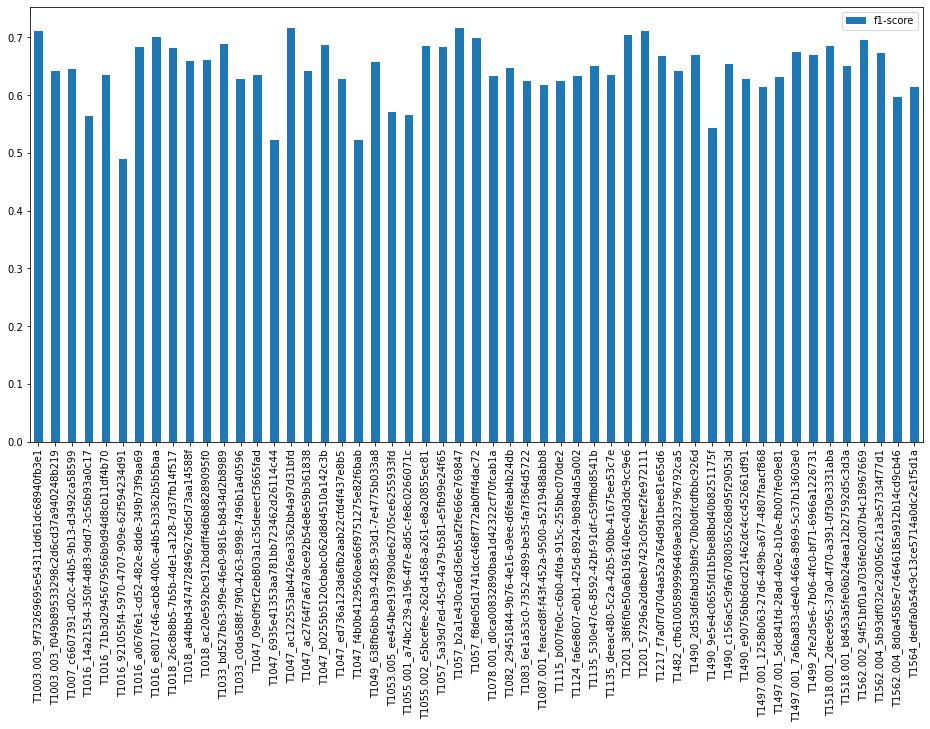

In [32]:
import matplotlib.pyplot as plt

filtered_report = report_df[(report_df['support'] == 256000)]
# filtered_report[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize = (12,8))
filtered_report[['f1-score']].plot(kind='bar', figsize = (16,8))
plt.show()

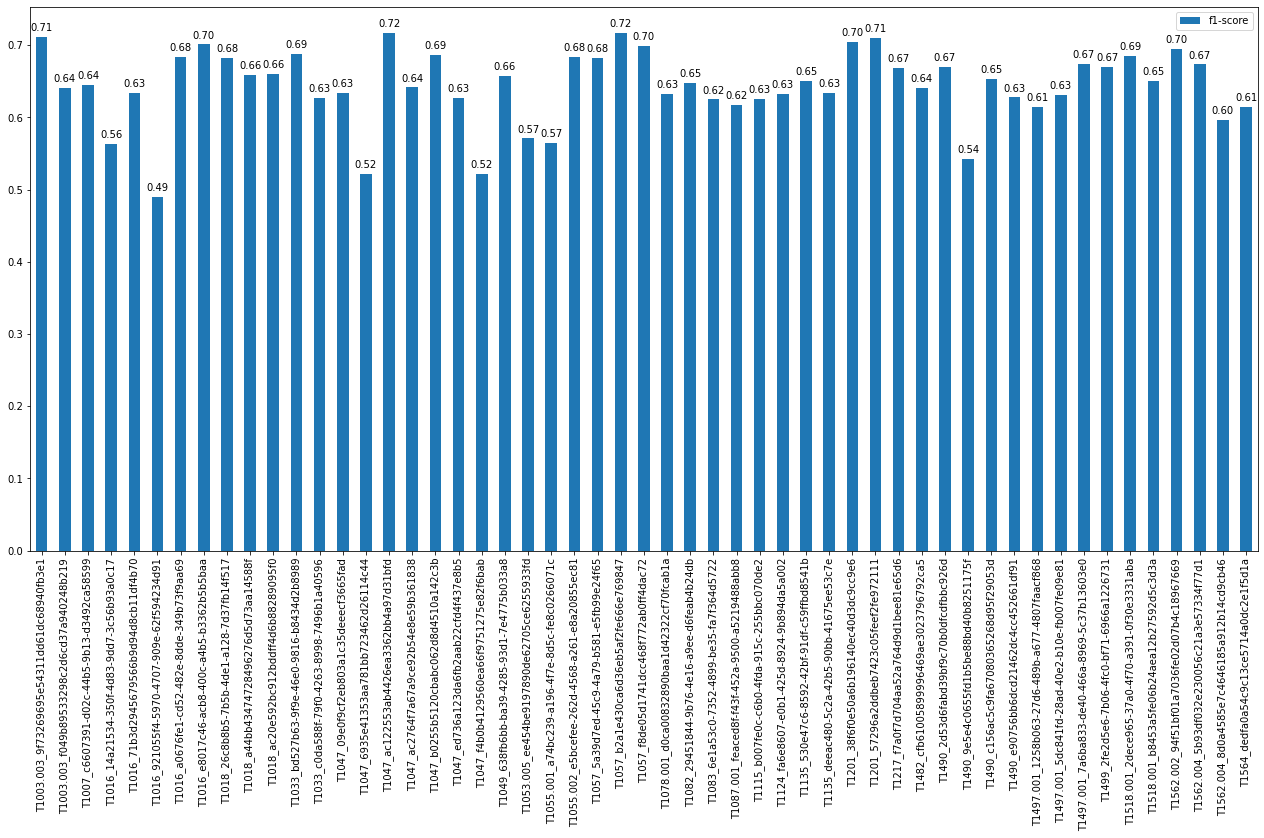

In [40]:
ax = filtered_report[['f1-score']].plot(kind='bar', figsize=(22,10))

# 添加 f1-score 值到 bar 上方
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', 
                va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.show()

### test of valid and test part is ``graph``

- 60 APs in training x 10000times
- 5 APs in validation x 4 times
- 3 APs in test x 4 times
- Batch size = 4

In [ ]:
# load the pretrained model
pretrained_model_path = '../checkpoint_graphSAGE/best_model_GraphSAGE_transR_50_hidden_dim.pt'
model.load_state_dict(torch.load(pretrained_model_path))

model.to(device)
model.eval()

total = 0
correct = 0
count = 0

true_labels = []
predicted_labels = []

with torch.no_grad():
    for batched_g in tqdm(dataloaders['test'], desc="Testing", position=0, leave=True):
#         print(f"data:{data[1]}")
        loss, accuracy, predicted = model_fn(batched_g, model, criterion, device, count, which_type='test')
        labels = batched_g.edata['label'].to(device)
        
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        
        if count % 5000 == 0:
            add_log_msg(f"labels: {labels} {labels.shape}")
            add_log_msg(f"predicted: {predicted} {predicted.shape}")
            
        count += 1
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

add_log_msg(f'Test Accuracy: {100 * correct / total} %\n\n\n')


# ======================================== handlig the output excel files ========================================
# mapping_file = './new_mapping.txt'
# label_mapping = {}
# with open(mapping_file, 'r') as f:
#     for line in f:
#         parts = line.strip().split(': ')
#         label_mapping[int(parts[1])] = parts[0]
        
# 将映射后的标签应用到true和predicted标签列表
mapped_true_labels = [label_mapping[label] for label in true_labels]
mapped_predicted_labels = [label_mapping[label] for label in predicted_labels]

# 生成Scikit-learn报告信息的DataFrame
report_data = classification_report(mapped_true_labels, mapped_predicted_labels, output_dict=True)
report_df = pd.DataFrame(report_data).transpose()

# mapped_true_labels_np = np.array(mapped_true_labels)
# mapped_predicted_labels_np = np.array(mapped_predicted_labels)

# print("mapped_true_labels 的形状:", mapped_true_labels_np.shape)
# print("mapped_predicted_labels 的形状:", mapped_predicted_labels_np.shape)

report_folder = 'classification_report'
os.makedirs(report_folder, exist_ok=True)

count = 0
while True:
    report_filename = f'classification_report-transE_50-graphSAGE-{count}.xlsx'
    labels_filename = f'mapped_true_predicted_labels-transE_50-graphSAGE-{count}.xlsx'
    
    report_path = os.path.join(report_folder, report_filename)
    labels_path = os.path.join(report_folder, labels_filename)
    
    if not os.path.exists(report_path) and not os.path.exists(labels_path):
        break
    count += 1

    
report_df.to_excel(report_path, index_label='Label')

mapped_labels_df = pd.DataFrame({'true_label': mapped_true_labels, 'predicted_label': mapped_predicted_labels})
mapped_labels_df.to_excel(labels_path, index=False)

add_log_msg(f"report path: {report_path}")
add_log_msg(f"label path: {labels_path}")

mapped_report = classification_report(mapped_true_labels, mapped_predicted_labels)
add_log_msg(f"mapped_report:\n{mapped_report}")